
# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from statistics import mean
from scipy.stats import tmean
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from sklearn.inspection import plot_partial_dependence

In [3]:
# loading csv
df_original = pd.read_csv('data/final_dataset.csv').drop("Unnamed: 0", axis=1)

df = df_original.copy()

Columns (53) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
# df_original[df_original["Name"] == "Mohamed-Salah"][["xP"]].head(80).tail(40)

In [5]:
df = df.rename(columns={'GW_x': 'GW'})
# df = df[~(df['position'].isin(['GK']))]
# df = df[df['position'].isin(['MID'])]

In [6]:
# df_original[["expected_goals", "xG"]]

In [7]:
# df_original["goals_conceded"].unique()

In [8]:
# df_original.isnull().sum(axis=0).sort_values(ascending=False).head(60)

In [9]:
# df_original.columns.to_list()

In [10]:
# df["position"].unique()

In [11]:
df.shape

(24683, 117)

# Features

In [12]:
# rolling_gameweeks = [2, 3, 5, 10, 20, 30]
rolling_gameweeks = [2, 4, 30]

to_predict = ["total_points"]
features1 = [
             "Was Home", # Home/Away
             "Team rating", "Opp rating", "Rating Difference" # Team ratings
             ]
features_to_roll = [
                "Min", "Start", # time played
                'Gls', 'Sh', 'SoT', # Goals
                'Ast', # Assists
                'CrdY', 'CrdR', # Cards
                "xG", 'xAG', # Expected
                'CS', # Defence
                'Team Score', 'Opp Score', 'Team Result', # Team form
                # "xGPoints", "CSPoints", # Position-scaled
                # "Cmp%", "PrgP", "PrgC", "Succ", "PKwon",
                # 'bonus', 'bps', # Bonus
                # 'influence', 'creativity', 'threat', 'ict_index', # ICT
                "total_points", "Baseline Points", "bonus" # FPL points
            ]
info = ["Name", "GW", "Season", "Squad", "Opponent", "Was Home", "Team rating", "Opp rating", "position"]

In [13]:
# df[features_to_roll + info].isnull().sum(axis=0).sort_values(ascending=False).head(30)

# Preparing dataset

In [14]:
df["Rating Difference"] = df["Team rating"] / df["Opp rating"]
# df["Rating Difference2"] = df["Team rating"] > df["Opp rating"]
df["Baseline Points"] = df["total_points"] - df["bonus"]

In [15]:
def calculate_team_points(row):
    if row['Team Score'] > row['Opp Score']:
        return 3
    elif row['Team Score'] == row['Opp Score']:
        return 1
    else:
        return 0
    
df['Team Result'] = df.apply(calculate_team_points, axis=1)

In [16]:
def calculate_xg_points(row):
    if row["position"] == "GK":
        return row["xG"] * 6
    elif row["position"] == "DEF":
        return row["xG"] * 6
    elif row["position"] == "MID":
        return row["xG"] * 5
    elif row["position"] == "FWD":
        return row["xG"] * 4
    else:
        return row["xG"] * 5

df["xGPoints"] = df.apply(calculate_xg_points, axis=1)

In [17]:
def calculate_cs_points(row):
    if row["position"] == "GK":
        return row["xG"] * 4
    elif row["position"] == "DEF":
        return row["xG"] * 4
    elif row["position"] == "MID":
        return row["xG"] * 1
    elif row["position"] == "FWD":
        return row["xG"] * 0
    else:
        return row["xG"] * 1

df["CSPoints"] = df.apply(calculate_cs_points, axis=1)

In [18]:
def add_rolling_features(df, features1, features_to_roll):
    features = features1
    
    for r in rolling_gameweeks:
        form_means = df.groupby(["Name"])[features_to_roll].rolling(r, min_periods=1).mean().groupby(["Name"]).shift(1).reset_index()
        form_means = form_means.fillna(method='bfill')
        
        form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
        features += form_means.columns.tolist()
        features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
        df = pd.concat([df, form_means], axis=1)
        
    return df, features

In [19]:
def ohe(df, ohe_columns, features):
    # one hot encoding
    for c in ohe_columns:
        ohe_c = pd.get_dummies(df[c], dtype="int64")
        df = pd.concat([df, ohe_c], axis=1)

        features += ohe_c.columns.tolist()
        
    return df, features

In [20]:
def label_encoding(df, column_to_encode):
    
    mapping_dict = {
        'Y': 2,
        'Y*': 1,
        'N': 0,
    }
    
    df[column_to_encode] = df[column_to_encode].map(mapping_dict)
    
    return df

In [21]:
df = df.reset_index()

In [22]:
df, features = add_rolling_features(df, features1, features_to_roll)

In [23]:
# df, features = ohe(df, ["position"], features)

In [24]:
df = label_encoding(df, "Start")

In [25]:
# dropping unwanted columns
features = [col for col in features if not col.startswith('level')]
df = df[np.unique(features + info + to_predict)]

In [26]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [27]:
# dropping NaNs
df = df.dropna(axis=0)

In [28]:
df = df.set_index(["Name", "Season", "GW"], drop=False)

In [29]:
df.columns

Index(['Ast_2', 'Ast_30', 'Ast_4', 'Baseline Points_2', 'Baseline Points_30',
       'Baseline Points_4', 'CS_2', 'CS_30', 'CS_4', 'CrdR_2', 'CrdR_30',
       'CrdR_4', 'CrdY_2', 'CrdY_30', 'CrdY_4', 'GW', 'Gls_2', 'Gls_30',
       'Gls_4', 'Min_2', 'Min_30', 'Min_4', 'Name', 'Opp Score_2',
       'Opp Score_30', 'Opp Score_4', 'Opp rating', 'Opponent',
       'Rating Difference', 'Season', 'Sh_2', 'Sh_30', 'Sh_4', 'SoT_2',
       'SoT_30', 'SoT_4', 'Squad', 'Team Result_2', 'Team Result_30',
       'Team Result_4', 'Team Score_2', 'Team Score_30', 'Team Score_4',
       'Team rating', 'Was Home', 'bonus_2', 'bonus_30', 'bonus_4', 'position',
       'total_points', 'total_points_2', 'total_points_30', 'total_points_4',
       'xAG_2', 'xAG_30', 'xAG_4', 'xG_2', 'xG_30', 'xG_4'],
      dtype='object')

In [30]:
df.shape

(22151, 59)

# Choosing features and splitting data

In [31]:
GAMEWEEK_TO_PREDICT = 30
SEASON_TO_PREDICT = "2022-23"

In [32]:
# gameweeks 6-14 is training data, gw 15 is test data
X_train = df[((df["Season"] < SEASON_TO_PREDICT) | (df["GW"] <= GAMEWEEK_TO_PREDICT - 1))][features].reset_index(drop=True)
y_train = df[((df["Season"] < SEASON_TO_PREDICT) | (df["GW"] <= GAMEWEEK_TO_PREDICT - 1))][to_predict].reset_index(drop=True)

In [33]:
X_test = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [34]:
X_test_all_remaining = df[(df["GW"] >= GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test_all_remaining = df[(df["GW"] >= GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [35]:
X_train.shape, X_test.shape

((18822, 52), (375, 52))

# Model

In [36]:
class HybridModel:
    def __init__(self, models, names, weights):
        self.models = models
        self.model_names = names
        self.weights = weights
    
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        
    def predict(self, X):
        model_preds = [model.predict(X) for model in self.models]
        preds = []
        for i in range(len(model_preds[0])):
            preds.append(np.mean([x[i] for x in model_preds]))
        return preds
    
    def evaluate(self, X, y):
        ys = [np.expm1(model.predict(X)) for model in self.models]
        y_ensemble = self.predict(X)
        
        rmsle_ys = [(mean_squared_log_error(y, y_model) ** 0.5) for y_model in ys]
        rmsle_ensemble = mean_squared_log_error(y, y_ensemble) ** 0.5
        
        for i in range(0, len(self.models)):
            print(f"RMSLE on {self.model_names[i]} model: {rmsle_ys[i]}")
        print(f"RMSLE on ensemble model: {rmsle_ensemble}")

In [37]:
lgbm = LGBMRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

names = [
    "LGBM",
    "XGB",
    "GBR"
]

weights = [
    1,
    1,
    1
]

# hybrid arguments
models = [
    lgbm, 
    xgb, 
    gbr
]

model = HybridModel(models, names, weights)

In [38]:
model = GradientBoostingRegressor(random_state=42)
# model = LGBMRegressor(random_state=42)
# model = XGBRegressor(random_state=42)
# model = RandomForestRegressor()

In [39]:
%%time
model.fit(X_train, np.array(y_train).ravel())

CPU times: total: 7.3 s
Wall time: 7.43 s


GradientBoostingRegressor(random_state=42)

# Evaluation

In [40]:
def get_predictions(model, df, X, all_remaining=False):
    # make predictions on the test data
    predictions = model.predict(X)
    
    if all_remaining:
        df_predictions = df[(df["GW"] >= GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
    else:
        df_predictions = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
        
    df_predictions.loc[:, "pred"] = predictions
    
    preds = df_predictions[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False)
    
    return preds, predictions

In [41]:
preds, predictions = get_predictions(model, df, X_test)

In [42]:
def pairwise_accuracy(predicted_scores, true_scores):
    if len(predicted_scores) != len(true_scores):
        raise ValueError("The length of predicted_scores and true_scores must be the same.")

    num_pairs = 0
    num_correct_pairs = 0

    for i in range(len(predicted_scores)):
        for j in range(i + 1, len(predicted_scores)):
            # Check if the predicted order matches the true order
            if (predicted_scores[i] > predicted_scores[j] and true_scores[i] > true_scores[j]) or \
               (predicted_scores[i] < predicted_scores[j] and true_scores[i] < true_scores[j]):
                num_correct_pairs += 1
            num_pairs += 1

    pairwise_accuracy = num_correct_pairs / num_pairs
    return pairwise_accuracy

In [43]:
def get_top_performer_names(df, no_top, no_gws):
    return df.reset_index(drop=True).groupby("Name")["total_points"].mean().groupby("Name").tail(no_gws).sort_values(ascending=False).head(no_top).index.to_list()

In [44]:
def pairwise_accuracy_topX(model, df, top_x):
    top_performers = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, top_x, 50)))]
    X = top_performers[features].reset_index(drop=True)
    y = np.array(top_performers[to_predict].reset_index(drop=True))
    preds = model.predict(X)
    
    return  pairwise_accuracy(preds, y)

In [45]:
def evaluate(model, df, predictions, y_true):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)

    pairwise_acc = pairwise_accuracy(np.array(y_true), predictions)
    pairwise_accuracy_top20 = pairwise_accuracy_topX(model, df, 20)
    pairwise_accuracy_top100 = pairwise_accuracy_topX(model, df, 100)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("Pairwise accuracy:", pairwise_acc)
    print("Pairwise accuracy @TOP100:", pairwise_accuracy_top100)
    print("Pairwise accuracy @TOP20:", pairwise_accuracy_top20)

In [46]:
# df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, 20, 50)))].columns

In [47]:
evaluate(model, df, predictions, y_test)

MAE: 1.748185129677037
MSE: 6.055942730718969
Pairwise accuracy: 0.5583458110516935
Pairwise accuracy @TOP100: 0.5535014005602241
Pairwise accuracy @TOP20: 0.6209150326797386


In [48]:
# df[df["Name"] == "Abdoulaye-Doucoure"][info]

In [49]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

# Valid predictions

In [50]:
preds.head(30)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
126,Harry-Kane,30,2022-23,Tottenham,Brighton,1.0,1848.280518,1835.872314,FWD,9.0,6.199173
109,Erling-Haaland,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,FWD,12.0,5.478152
144,Ivan-Toney,30,2022-23,Brentford,Newcastle Utd,1.0,1792.455444,1871.874634,FWD,4.0,5.326022
156,James-Maddison,30,2022-23,Leicester City,Bournemouth,1.0,1736.191162,1656.900146,MID,2.0,4.886060
265,Mohamed-Salah,30,2022-23,Liverpool,Arsenal,1.0,1929.042725,1956.794434,MID,5.0,4.792885
285,Ollie-Watkins,30,2022-23,Aston Villa,Nott'ham Forest,1.0,1799.512573,1643.347290,FWD,7.0,4.728057
242,Marcus-Rashford,30,2022-23,Manchester Utd,Everton,1.0,1880.802124,1694.970825,MID,6.0,4.504102
214,Kieran-Trippier,30,2022-23,Newcastle Utd,Brentford,0.0,1871.874634,1792.455444,DEF,2.0,4.447879
339,Son-Heung-min,30,2022-23,Tottenham,Brighton,1.0,1848.280518,1835.872314,MID,7.0,4.424857
131,Harvey-Barnes,30,2022-23,Leicester City,Bournemouth,1.0,1736.191162,1656.900146,MID,2.0,4.319742


In [51]:
preds[preds["Squad"] == "Manchester City"].head(20)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
109,Erling-Haaland,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,FWD,12.0,5.478152
145,Jack-Grealish,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,12.0,3.691956
316,Rodri,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,2.0,3.657776
209,Kevin-De-Bruyne,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,9.0,3.597757
98,Ederson,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,GK,2.0,3.569730
139,Ilkay-Gundogan,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,2.0,3.541812
320,Ruben-Dias,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,DEF,2.0,3.341755
272,Nathan-Ake,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,DEF,2.0,3.341755
236,Manuel-Akanji,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,DEF,2.0,3.216828
187,John-Stones,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,DEF,0.0,3.149705


In [52]:
# preds[preds["position"] == "FWD"].head(15)
preds_all, predictions_all = get_predictions(model, df, X_test_all_remaining, True)

In [63]:
preds_all.head(15)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
1011,Erling-Haaland,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,FWD,2.0,8.420006
2391,Mohamed-Salah,37,2022-23,Liverpool,Aston Villa,1.0,1958.159424,1815.086426,MID,5.0,6.565082
1858,Kevin-De-Bruyne,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,MID,3.0,6.444366
2388,Mohamed-Salah,34,2022-23,Liverpool,Tottenham,1.0,1936.814331,1820.079712,MID,7.0,6.381458
440,Callum-Wilson,37,2022-23,Newcastle Utd,Leicester City,1.0,1882.392212,1710.457275,FWD,2.0,6.381167
2392,Mohamed-Salah,38,2022-23,Liverpool,Southampton,0.0,1953.153564,1619.777344,MID,5.0,6.344945
1181,Harry-Kane,31,2022-23,Tottenham,Bournemouth,1.0,1854.798462,1668.258545,FWD,2.0,6.282772
1013,Erling-Haaland,37,2022-23,Manchester City,Chelsea,1.0,2090.251709,1797.171265,FWD,1.0,6.275399
1185,Harry-Kane,35,2022-23,Tottenham,Crystal Palace,1.0,1816.056030,1752.288574,FWD,8.0,6.241497
1180,Harry-Kane,30,2022-23,Tottenham,Brighton,1.0,1848.280518,1835.872314,FWD,9.0,6.199173


In [61]:
preds_all[preds_all["Name"] == "Mohamed-Salah"].sort_values(by=["GW"])

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
2384,Mohamed-Salah,30,2022-23,Liverpool,Arsenal,1.0,1929.042725,1956.794434,MID,5.0,4.792885
2385,Mohamed-Salah,31,2022-23,Liverpool,Leeds United,0.0,1928.520996,1698.080566,MID,14.0,4.883771
2386,Mohamed-Salah,32,2022-23,Liverpool,Nott'ham Forest,1.0,1930.005737,1626.679321,MID,7.0,6.061476
2387,Mohamed-Salah,33,2022-23,Liverpool,West Ham,0.0,1931.599731,1774.066772,MID,2.0,4.677684
2388,Mohamed-Salah,34,2022-23,Liverpool,Tottenham,1.0,1936.814331,1820.079712,MID,7.0,6.381458
2389,Mohamed-Salah,35,2022-23,Liverpool,Brentford,1.0,1943.223999,1784.843750,MID,10.0,5.477138
2390,Mohamed-Salah,36,2022-23,Liverpool,Leicester City,0.0,1947.327637,1712.013672,MID,12.0,5.114685
2391,Mohamed-Salah,37,2022-23,Liverpool,Aston Villa,1.0,1958.159424,1815.086426,MID,5.0,6.565082
2392,Mohamed-Salah,38,2022-23,Liverpool,Southampton,0.0,1953.153564,1619.777344,MID,5.0,6.344945


In [62]:
preds_all[preds_all["Name"] == "Erling-Haaland"].sort_values(by=["GW"])

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
1007,Erling-Haaland,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,FWD,12.0,5.478152
1008,Erling-Haaland,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,12.0,4.499048
1014,Erling-Haaland,32,2022-23,Manchester City,Brighton,0.0,2091.929932,1829.306519,FWD,5.0,4.345900
1009,Erling-Haaland,33,2022-23,Manchester City,Arsenal,1.0,2060.745117,1938.854858,FWD,14.0,3.877083
1010,Erling-Haaland,34,2022-23,Manchester City,Fulham,0.0,2067.576904,1720.540771,FWD,8.0,5.454932
1011,Erling-Haaland,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,FWD,2.0,8.420006
1012,Erling-Haaland,36,2022-23,Manchester City,Everton,0.0,2074.110596,1697.794434,FWD,7.0,5.323208
1013,Erling-Haaland,37,2022-23,Manchester City,Chelsea,1.0,2090.251709,1797.171265,FWD,1.0,6.275399
1015,Erling-Haaland,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,FWD,0.0,5.642700


# Feature importance and influence

In [54]:
# plot_importance(model)

In [55]:
# fig, ax = plt.subplots(figsize=(16, 8))
# plot_partial_dependence(model, X_train, features, ax=ax)

In [56]:
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

Permutation explainer: 376it [00:28,  9.97it/s]                                                                                                                                    


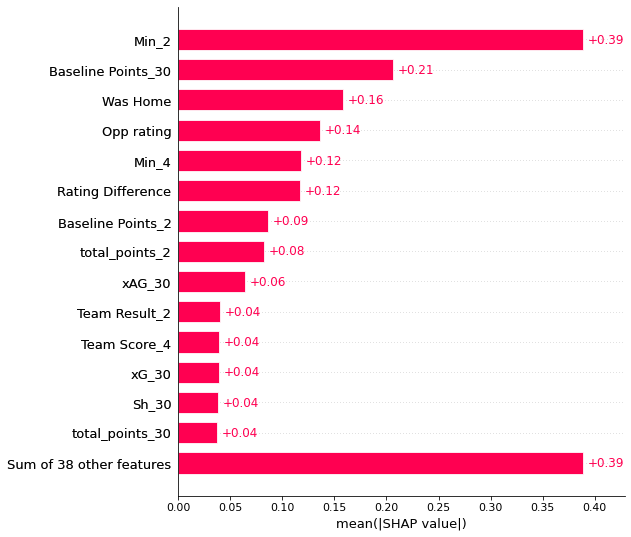

In [57]:
shap.plots.bar(shap_values, max_display=15)

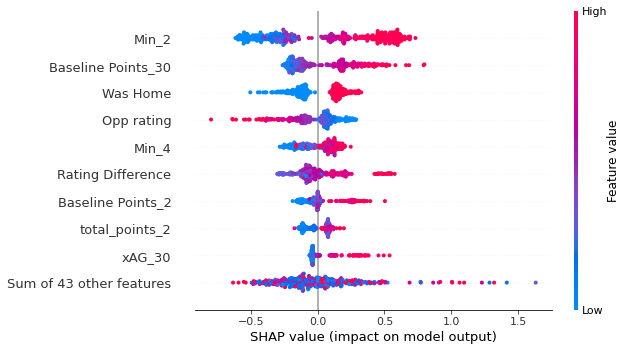

In [58]:
shap.plots.beeswarm(shap_values)

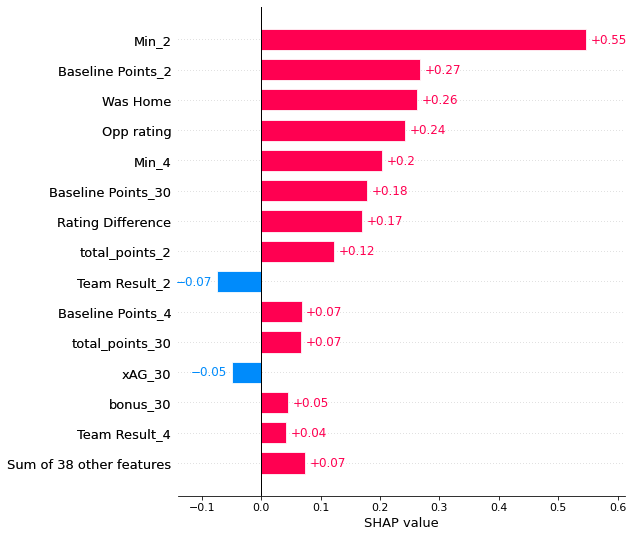

In [59]:
shap.plots.bar(shap_values[105], max_display=15)